# Gradient-Descent
There are three common gradient descent methods: **batch gradient descent(BGD), Stochastic Gradient Descent(SGD), mini-batch gradient descent(MBGD)**.

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [25]:
# define 2D function 
def func(x, y,noise=False,iteration=None):
    # main part   multi-local extrema
    main_func = (torch.sin(0.5 * x) * torch.cos(0.3 * y) +
                 torch.sin(0.2 * x * y) +
                 0.1 * (x ** 2 + y ** 2) +
                 2 * torch.sin(x + 0.5 * y))
    # add noise to simulate SGD
    if noise:
        noise_level = 0.5  # basic noise
        if iteration is not None:
            noise_level *= (1 + 0.3 * torch.sin(torch.tensor(iteration / 3.0)))
        return main_func + noise_level * torch.randn(1) * 2
    return main_func

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


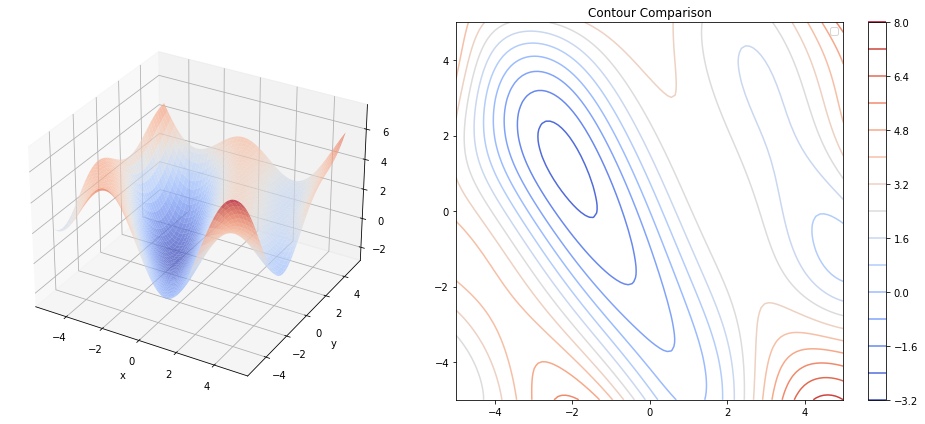

In [22]:
# show
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j]), False).item()


fig = plt.figure(figsize=(14, 6))

# 3D surface
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 2D contour map
ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()


In [26]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)


# Opti param
learning_rate = 0.4
iterations = 50
sample_size = 10  # 每次迭代评估的样本点数

## BGD
**Steps:**
* Init parameters, eg. $w$
* Calculate gradient, calculate gradient $G(w)$ of all samples, $n$ is the num of samples, $L(w;x_i,y_i)$ is the loss of simple sample
$$
\bigtriangledown G(w)=\frac{1}{n}\sum_{i=1}^n \bigtriangledown L(w;x_i,y_i) 
$$
* Update parameters, upate param through gradient direction($\gamma$ is learning rate)
$$
w_{t+1}=w_t-\gamma \bigtriangledown G(w)
$$
* Iteration, Iterate until the gradient converges or the maximum number of iterations is reached.


**pros:**
* Theoretically guaranteed to converge to the global optimum (for convex functions) or local optimum (for non-convex functions).
* The gradient calculation is unbiased and suitable for small or medium-sized datasets.

**cons:**
* Slow computation per iteration for large datasets.
* Not suitable for online learning (i.e., cannot gradually incorporate new data).

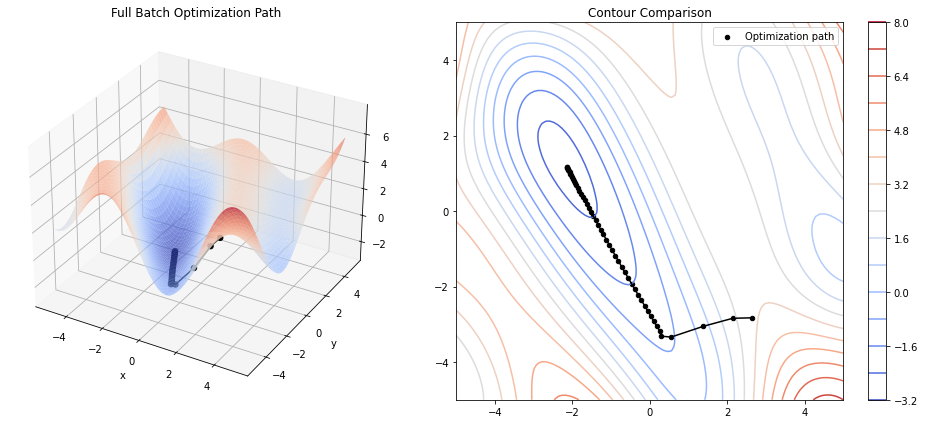


Final result:
x = -2.1478, y = 1.1747
Minimum value f(x,y) = -2.7091


In [29]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# process storage
history = []

# BGD
for i in range(iterations):
    # clear gradient
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    # value 4 add gradient
    grad_x = 0
    grad_y = 0

    # all batch
    for _ in range(sample_size):
        # no noise
        z = func(x, y)

        z.backward()
        
        grad_x += x.grad.item()
        grad_y += y.grad.item()

        # clear
        x.grad.zero_()
        y.grad.zero_()

    # calc mean gradient
    avg_grad_x = grad_x / sample_size
    avg_grad_y = grad_y / sample_size

    # update
    with torch.no_grad():
        x -= learning_rate * avg_grad_x
        y -= learning_rate * avg_grad_y

        # record current 
        true_z = func(x, y)
        history.append([x.item(), y.item(), true_z.item()])

# visualization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Full Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='Optimization path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


## SGD
**Steps:**
* Init parameters, eg. $w$
* Randomly shuffle data,shuffle the order of the training data to prevent the model from being biased due to the data sequence.
* Calculate gradient, calculate gradient $G(w)$ of this sample
$$
\bigtriangledown G(w)= \bigtriangledown L(w;x_i,y_i) 
$$
* Update parameters, upate param through gradient direction($\gamma$ is learning rate)
$$
w_{t+1}=w_t-\gamma \bigtriangledown G(w)
$$
* Iteration, Iterate until the gradient converges or the maximum number of iterations is reached.


**pros:**
* It has a fast computing speed and is particularly suitable for large-scale datasets. 
* It can escape from local minima (due to the introduction of noise). 
* Has strong online learning capabilities and can handle dynamically updated data.

**cons:**
* The convergence path is tortuous and there is a lot of noise. 
* It is sensitive to the learning rate and requires careful adjustment. 
* It may be difficult to converge to the precise minimum value point.

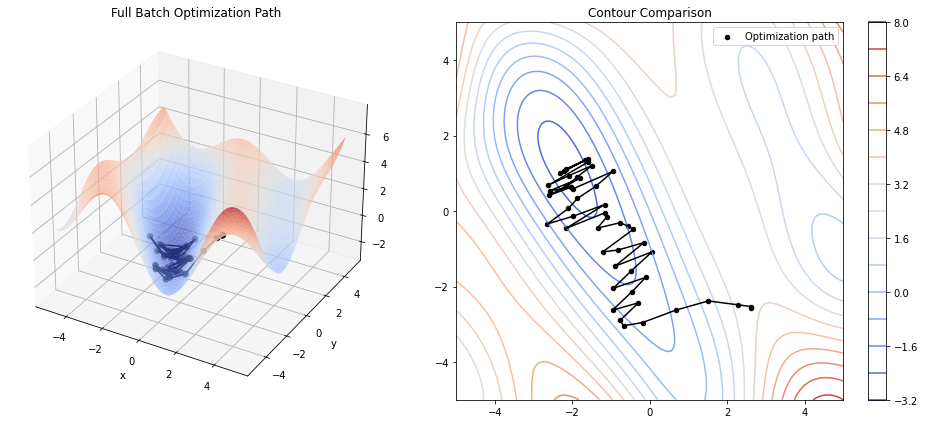


Final result:
x = -2.3196, y = 1.0052
Minimum value f(x,y) = -2.6256


In [30]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# process storage
history = []
batch_history = []  # location with noise

# SGD
# calc grad with noise,应该基于扰动后的位置
for i in range(iterations):
    # add noise
    noisy_x = x + torch.randn(1) * 0.5  
    noisy_y = y + torch.randn(1) * 0.5

    # z with noise
    z = func(noisy_x, noisy_y, True, i)

    z.backward()

    with torch.no_grad():
        x -= learning_rate * x.grad
        y -= learning_rate * y.grad

        # true z
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])

        # z with noise
        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])
        # clear
        x.grad.zero_()
        y.grad.zero_()

#  visualization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Full Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='Optimization path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


**Why add noise to the parameters in SGD**
* **Improve Generalization**: By forcing the model towards flatter minima, reducing overfitting.
* **Enhance Robustness**: Through an implicit model ensemble, making the model less sensitive to parameter perturbations.
* **Enhance Robustness**: Through an implicit model ensemble, making the model less sensitive to parameter perturbations.

## MBGD
**Steps:**
* Init parameters, randomly select the initial parameters,eg. $w$, determin the batch size $m$
* Randomly shuffle data,shuffle the order of the training data to prevent the model from being biased due to the data sequence.
* Calculate gradient, calculate gradient $G(w)$ of this samples, $m$ is the num of batch samples, $L(w;x_i,y_i)$ is the loss of simple sample
$$
\bigtriangledown G(w)=\frac{1}{m}\sum_{i=1}^m \bigtriangledown L(w;x_i,y_i) 
$$
* Update parameters, upate param through gradient direction($\gamma$ is learning rate)
$$
w_{t+1}=w_t-\gamma \bigtriangledown G(w)
$$
* Iteration, Iterate until the gradient converges or the maximum number of iterations is reached.


**pros:**
* Compared with BGD, MBGD reduces the computational load per iteration and speeds up the training process.
* Compared with SGD, the gradient estimation of MBGD is more stable, reduces the fluctuation of the update direction, and helps achieve more stable convergence.
* The balance between computational load and gradient estimation stability can be achieved by adjusting the batch size.

**cons:**
* The optimal batch size needs to be determined through experiments and parameter tuning.

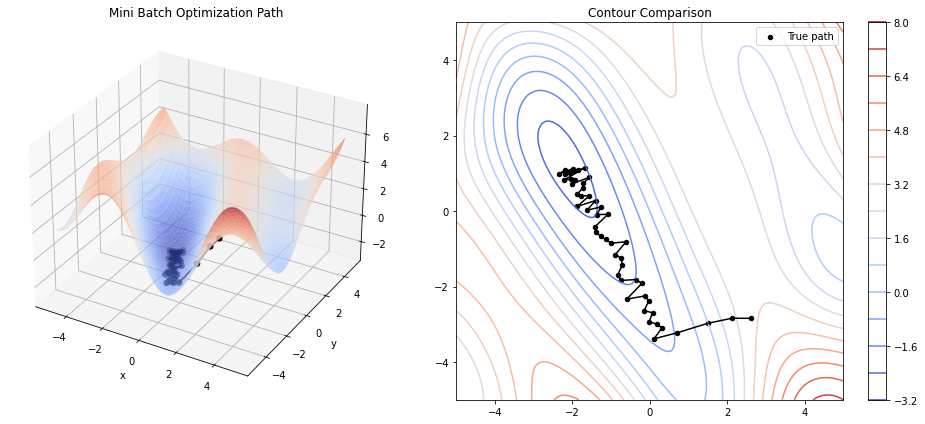


Final result:
x = -2.1792, y = 1.0884
Minimum value f(x,y) = -2.6989


In [31]:
# init param (where to start)
x = torch.tensor([3.0], requires_grad=True)
y = torch.tensor([-3.0], requires_grad=True)

# process storage
history = []
batch_history = []  

# MBGD
for i in range(iterations):
    # clear
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()

    grad_x = 0
    grad_y = 0

    # mini-batch
    for _ in range(batch_size):
        noisy_x = x + torch.randn(1) * 0.5
        noisy_y = y + torch.randn(1) * 0.5

        z = func(noisy_x, noisy_y, True, i)

        z.backward()

        grad_x += x.grad.item()
        grad_y += y.grad.item()

        batch_history.append([noisy_x.item(), noisy_y.item(), z.item()])

        # clear
        x.grad.zero_()
        y.grad.zero_()
    # calc mean
    avg_grad_x = grad_x / batch_size
    avg_grad_y = grad_y / batch_size

    # Update
    with torch.no_grad():
        x -= learning_rate * avg_grad_x
        y -= learning_rate * avg_grad_y

        # record true
        true_z = func(x, y, False)
        history.append([x.item(), y.item(), true_z.item()])


# visulization
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5 , 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

history = np.array(history)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)
ax1.scatter(history[:, 0], history[:, 1], history[:, 2], c='black', s=30)
ax1.plot(history[:, 0], history[:, 1], history[:, 2], 'k-', lw=1.5)
ax1.set_title('Mini Batch Optimization Path')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax3 = fig.add_subplot(122)
contour = ax3.contour(X, Y, Z, 15, cmap='coolwarm')
ax3.scatter(history[:, 0], history[:, 1], c='black', s=20, label='True path')
ax3.plot(history[:, 0], history[:, 1], 'k-', lw=1.5)
ax3.set_title('Contour Comparison')
ax3.legend()
plt.colorbar(contour, ax=ax3)

plt.tight_layout()
plt.show()

# output
print(f"\nFinal result:")
print(f"x = {x.item():.4f}, y = {y.item():.4f}")
print(f"Minimum value f(x,y) = {func(x, y).item():.4f}")


reference:https://juejin.cn/post/7496394589672243219